## Analog_Reading-eg: 25kV

In [1]:
import sys
import cv2
import numpy as np
from ultralytics import YOLO

def draw_obb(image, obb):
    # Draw the oriented bounding box on the image
    if obb is not None:
        for box in obb.xyxyxyxy.cpu().numpy():
            box = box.reshape(4, 2).astype(int)
            cv2.polylines(image, [box], isClosed=True, color=(0, 255, 0), thickness=2)
    return image

def get_center_point(box):
    # Calculate center point of a bounding box
    pts = box.reshape(4, 2)
    center_x = np.mean(pts[:, 0])
    center_y = np.mean(pts[:, 1])
    return (center_x, center_y)

def calculate_meter_reading(needle_corners, number_positions):
    # Define standard number values for labeling from left to right
    number_values = [0, 5, 10, 15, 20, 25, 30]
    
    # Sort number positions by x-coordinate (left to right)
    sorted_positions = sorted(number_positions, key=lambda x: x[1][0])
    
    # Replace the detected values with our standardized values
    labeled_positions = []
    for i, (_, position) in enumerate(sorted_positions):
        if i < len(number_values):
            labeled_positions.append((number_values[i], position))
    
    # Calculate midpoint between corner 3 and corner 4 as the needle tip
    needle_tip_x = (needle_corners[2][0] + needle_corners[3][0]) / 2
    needle_tip_y = (needle_corners[2][1] + needle_corners[3][1]) / 2
    needle_tip = np.array([needle_tip_x, needle_tip_y])
    
    # First check if needle is exactly at a number position
    for value, position in labeled_positions:
        distance = np.sqrt((needle_tip[0] - position[0])**2 + (needle_tip[1] - position[1])**2)
        if distance < 15:  # Threshold for "exact match"
            return value, "exact_midpoint"
    
    # If not exact, find the two numbers the needle is between
    left_value = None
    right_value = None
    left_position = None
    right_position = None
    
    for i in range(len(labeled_positions) - 1):
        curr_value, curr_pos = labeled_positions[i]
        next_value, next_pos = labeled_positions[i + 1]
        
        # Check if needle tip is between these two numbers (x-coordinate)
        if curr_pos[0] <= needle_tip[0] <= next_pos[0]:
            left_value = curr_value
            right_value = next_value
            left_position = curr_pos
            right_position = next_pos
            break
    
    # If needle is not between any two numbers, return the closest one
    if left_value is None or right_value is None:
        # Find the closest number
        min_distance = float('inf')
        closest_value = None
        
        for value, position in labeled_positions:
            distance = np.sqrt((needle_tip[0] - position[0])**2 + (needle_tip[1] - position[1])**2)
            if distance < min_distance:
                min_distance = distance
                closest_value = value
        
        return closest_value, "closest_midpoint"
    
    # Calculate interpolation based on x-coordinate position
    total_x_distance = right_position[0] - left_position[0]
    needle_x_distance = needle_tip[0] - left_position[0]
    
    # Calculate the ratio (0 to 1) of where the needle is between the two numbers
    ratio = needle_x_distance / total_x_distance if total_x_distance > 0 else 0
    
    # Calculate the interpolated value with one decimal place precision
    value_range = right_value - left_value
    interpolated_value = left_value + (ratio * value_range)
    
    # Round to one decimal place
    interpolated_value = round(interpolated_value, 1)
    
    return interpolated_value, "interpolated_midpoint"

def main(analog_readingng, image_path):
    # Load the YOLO OBB model for detection
    model_3 = YOLO(analog_readingng)
    
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image at", image_path)
        sys.exit(1)
    
    # Run inference using model_3 for detection
    results = model_3(image)
    
    # Variables to store needle and number positions
    needle_corners = None
    number_positions = []
    
    # Iterate over the results and process detections
    for r in results:
        if r.obb is not None:
            image = draw_obb(image, r.obb)
            
            boxes = r.obb.xyxyxyxy.cpu().numpy()
            classes = r.obb.cls.cpu().numpy()
            
            for i, (box, class_id) in enumerate(zip(boxes, classes)):
                class_name = r.names[int(class_id)]
                center = get_center_point(box)
                
                # Draw the center point for all detections
                cv2.circle(image, (int(center[0]), int(center[1])), 3, (0, 0, 255), -1)
                
                if class_name.lower() == "needle":
                    # Store all corners of the needle
                    needle_corners = box.reshape(4, 2)
                  
                elif class_name.isdigit() or class_name in ["0", "5", "10", "15", "20", "25", "30"] or class_name.lower() == "numbers":
                    number_positions.append((0, center)) 
    
    # Label the numbers from left to right for visualization
    if number_positions:
        number_values = [0, 5, 10, 15, 20, 25, 30]
        sorted_positions = sorted(number_positions, key=lambda x: x[1][0])
        
        # Draw the labels on the image
        for i, (_, position) in enumerate(sorted_positions):
            if i < len(number_values):
                label = str(number_values[i])
                cv2.putText(image, label, 
                           (int(position[0]), int(position[1]) - 15),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Calculate the meter reading if we have needle and numbers
    if needle_corners is not None and number_positions:
        # Calculate midpoint between corner 3 and corner 4 for visualization
        needle_tip_x = (needle_corners[2][0] + needle_corners[3][0]) / 2
        needle_tip_y = (needle_corners[2][1] + needle_corners[3][1]) / 2
        needle_tip = np.array([needle_tip_x, needle_tip_y])
                
        reading, method = calculate_meter_reading(needle_corners, number_positions)
        if reading is not None:
            result_text = f"Meter reading: {reading}"
            print(result_text)
            
            # Visualize the connection between the used needle midpoint and closest number
            sorted_positions = sorted(number_positions, key=lambda x: x[1][0])
            labeled_positions = []
            for i, (_, position) in enumerate(sorted_positions):
                if i < len(number_values):
                    labeled_positions.append((number_values[i], position))
            
            # Find the two values the needle is between (for interpolation visualization)
            left_pos = None
            right_pos = None
            
            for i in range(len(labeled_positions) - 1):
                curr_value, curr_pos = labeled_positions[i]
                next_value, next_pos = labeled_positions[i + 1]
                
                # Check if needle tip is between these two numbers (x-coordinate)
                if curr_pos[0] <= needle_tip[0] <= next_pos[0]:
                    left_pos = curr_pos
                    right_pos = next_pos
                    break
            
            # Draw visualization lines
            if "interpolated" in method and left_pos is not None and right_pos is not None:
                # Draw lines to both adjacent numbers
                cv2.line(image, 
                         (int(needle_tip[0]), int(needle_tip[1])), 
                         (int(left_pos[0]), int(left_pos[1])), 
                         (255, 0, 255), 1, cv2.LINE_AA)
                cv2.line(image, 
                         (int(needle_tip[0]), int(needle_tip[1])), 
                         (int(right_pos[0]), int(right_pos[1])), 
                         (255, 0, 255), 1, cv2.LINE_AA)
                
                # Draw the interpolation region
                pts = np.array([
                    [int(left_pos[0]), int(left_pos[1])],
                    [int(right_pos[0]), int(right_pos[1])],
                    [int(needle_tip[0]), int(needle_tip[1])]
                ], np.int32)
               
            else:
                # Find the closest position for non-interpolated readings
                closest_position = None
                min_distance = float('inf')
                
                for _, position in labeled_positions:
                    distance = np.sqrt((needle_tip[0] - position[0])**2 + 
                                     (needle_tip[1] - position[1])**2)
                    if distance < min_distance:
                        min_distance = distance
                        closest_position = position
                
                if closest_position is not None:
                    # Draw a line connecting the needle midpoint and the closest number
                    cv2.line(image, 
                            (int(needle_tip[0]), int(needle_tip[1])), 
                            (int(closest_position[0]), int(closest_position[1])), 
                            (255, 0, 255), 2)
        else:
            print("Needle position is out of range")
    else:
        if needle_corners is None:
            print("Needle not detected")
        if not number_positions:
            print("No numbers detected")
            
if __name__ == "__main__":
    analog_readingng = "Models/analog_reading_v2.pt"
    image_path = "cropped_images/297.png"
    main(analog_readingng, image_path)


0: 544x640 88.5ms
Speed: 5.0ms preprocess, 88.5ms inference, 4.0ms postprocess per image at shape (1, 3, 544, 640)
Meter reading: 20.5


## Anlog pipeline N2N --> detect and crop --> pass cropped region to through above funtion

In [1]:
import sys
import cv2
import numpy as np
from ultralytics import YOLO

# -----------------------------
# Part 1: Helper functions for cropping
# -----------------------------

def draw_obb(image, obb):
    """Draw oriented bounding boxes on an image."""
    boxes = obb.xyxyxyxy.cpu().numpy()
    for box in boxes:
        pts = box.reshape(4, 2).astype(np.int32)
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    return image

def order_points(pts):
    """Order 4 points as top-left, top-right, bottom-right, bottom-left."""
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def crop_region(image, obb):
    """
    Crop the meter region from the image using the OBB.
    Uses a perspective transformation based on the minimal area rectangle.
    """
    boxes = obb.xyxyxyxy.cpu().numpy()
    if len(boxes) == 0:
        return None
    # Use the first detected box for cropping.
    box = boxes[0]
    pts = box.reshape(4, 2).astype(np.float32)
    
    # Get the minimal area rectangle for the points.
    rect = cv2.minAreaRect(pts)
    width = int(rect[1][0])
    height = int(rect[1][1])
    if width <= 0 or height <= 0:
        return None

    # Destination points for the warp (top-left, top-right, bottom-right, bottom-left)
    dst_pts = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]], dtype=np.float32)
    
    # Order the source points and compute the perspective transform.
    ordered_pts = order_points(pts)
    M = cv2.getPerspectiveTransform(ordered_pts, dst_pts)
    cropped = cv2.warpPerspective(image, M, (width, height))
    return cropped

def detect_and_crop_region(analog_box_model, image_path):
    """
    Detect the meter region using analog_box.pt and return the cropped image.
    """
    model = YOLO(analog_box_model)
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image at", image_path)
        sys.exit(1)
    
    results = model(image)
    for r in results:
        if hasattr(r, "obb") and r.obb is not None:
            cropped = crop_region(image, r.obb)
            if cropped is not None:
                return cropped
    print("No meter detected.")
    sys.exit(1)

# -----------------------------
# Part 2: Meter reading functions (provided calculation code)
# -----------------------------

def get_center_point(box):
    """Calculate the center point of a bounding box (4 corners)."""
    pts = box.reshape(4, 2)
    center_x = np.mean(pts[:, 0])
    center_y = np.mean(pts[:, 1])
    return (center_x, center_y)

def calculate_meter_reading(needle_corners, number_positions):
    """
    Given the needle corners and number positions, calculate the meter reading.
    The numbers are standardized as [0, 5, 10, 15, 20, 25, 30].
    """
    number_values = [0, 5, 10, 15, 20, 25, 30]
    
    # Sort number positions left-to-right by x-coordinate.
    sorted_positions = sorted(number_positions, key=lambda x: x[1][0])
    labeled_positions = []
    for i, (_, position) in enumerate(sorted_positions):
        if i < len(number_values):
            labeled_positions.append((number_values[i], position))
    
    # Compute needle tip as midpoint between corner 3 and corner 4.
    needle_tip_x = (needle_corners[2][0] + needle_corners[3][0]) / 2
    needle_tip_y = (needle_corners[2][1] + needle_corners[3][1]) / 2
    needle_tip = np.array([needle_tip_x, needle_tip_y])
    
    # Check if needle tip exactly matches a number position.
    for value, position in labeled_positions:
        distance = np.sqrt((needle_tip[0] - position[0])**2 + (needle_tip[1] - position[1])**2)
        if distance < 15:  # threshold for "exact match"
            return value, "exact_midpoint"
    
    # If not an exact match, find the two numbers between which the needle lies.
    left_value = None
    right_value = None
    left_position = None
    right_position = None
    for i in range(len(labeled_positions) - 1):
        curr_value, curr_pos = labeled_positions[i]
        next_value, next_pos = labeled_positions[i + 1]
        if curr_pos[0] <= needle_tip[0] <= next_pos[0]:
            left_value = curr_value
            right_value = next_value
            left_position = curr_pos
            right_position = next_pos
            break

    # If not between any two, return the closest.
    if left_value is None or right_value is None:
        min_distance = float('inf')
        closest_value = None
        for value, position in labeled_positions:
            distance = np.sqrt((needle_tip[0] - position[0])**2 + (needle_tip[1] - position[1])**2)
            if distance < min_distance:
                min_distance = distance
                closest_value = value
        return closest_value, "closest_midpoint"
    
    # Interpolate based on x-distance.
    total_x_distance = right_position[0] - left_position[0]
    needle_x_distance = needle_tip[0] - left_position[0]
    ratio = needle_x_distance / total_x_distance if total_x_distance > 0 else 0
    value_range = right_value - left_value
    interpolated_value = left_value + (ratio * value_range)
    interpolated_value = round(interpolated_value, 1)
    
    return interpolated_value, "interpolated_midpoint"

def process_meter_reading(analog_reading_model, image):
    """
    Run detection on the provided (cropped) meter image using analog_reading_v2.pt,
    compute the meter reading, and print the result.
    """
    model = YOLO(analog_reading_model)
    results = model(image)
    
    needle_corners = None
    number_positions = []  # Each element is a tuple: (detected_label, center)
    
    # Process each detection result.
    for r in results:
        if hasattr(r, "obb") and r.obb is not None:
            image = draw_obb(image, r.obb)
            boxes = r.obb.xyxyxyxy.cpu().numpy()
            classes = r.obb.cls.cpu().numpy()
            
            for box, class_id in zip(boxes, classes):
                class_name = r.names[int(class_id)]
                center = get_center_point(box)
                cv2.circle(image, (int(center[0]), int(center[1])), 3, (0, 0, 255), -1)
                
                if class_name.lower() == "needle":
                    needle_corners = box.reshape(4, 2)
                # Check if class is a digit (or the word "numbers") representing meter numbers.
                elif class_name.isdigit() or class_name in ["0", "5", "10", "15", "20", "25", "30"] or class_name.lower() == "numbers":
                    number_positions.append((0, center))
    
    # Label the numbers (using standard ordering) on the image.
    if number_positions:
        number_values = [0, 5, 10, 15, 20, 25, 30]
        sorted_positions = sorted(number_positions, key=lambda x: x[1][0])
        for i, (_, position) in enumerate(sorted_positions):
            if i < len(number_values):
                label = str(number_values[i])
                cv2.putText(image, label, 
                            (int(position[0]), int(position[1]) - 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Compute and print the meter reading if needle and numbers are detected.
    if needle_corners is not None and number_positions:
        needle_tip_x = (needle_corners[2][0] + needle_corners[3][0]) / 2
        needle_tip_y = (needle_corners[2][1] + needle_corners[3][1]) / 2
        needle_tip = np.array([needle_tip_x, needle_tip_y])
                
        reading, method = calculate_meter_reading(needle_corners, number_positions)
        if reading is not None:
            result_text = f"Meter reading: {reading} ({method})"
            print(result_text)
            
            # Visualize connection between the needle tip and the nearest number.
            number_values = [0, 5, 10, 15, 20, 25, 30]
            sorted_positions = sorted(number_positions, key=lambda x: x[1][0])
            labeled_positions = []
            for i, (_, position) in enumerate(sorted_positions):
                if i < len(number_values):
                    labeled_positions.append((number_values[i], position))
            
            # Find adjacent numbers for interpolation visualization.
            left_pos = None
            right_pos = None
            for i in range(len(labeled_positions) - 1):
                curr_value, curr_pos = labeled_positions[i]
                next_value, next_pos = labeled_positions[i + 1]
                if curr_pos[0] <= needle_tip[0] <= next_pos[0]:
                    left_pos = curr_pos
                    right_pos = next_pos
                    break
            
            if "interpolated" in method and left_pos is not None and right_pos is not None:
                cv2.line(image, 
                         (int(needle_tip[0]), int(needle_tip[1])), 
                         (int(left_pos[0]), int(left_pos[1])), 
                         (255, 0, 255), 1, cv2.LINE_AA)
                cv2.line(image, 
                         (int(needle_tip[0]), int(needle_tip[1])), 
                         (int(right_pos[0]), int(right_pos[1])), 
                         (255, 0, 255), 1, cv2.LINE_AA)
            else:
                # Connect to closest number if not interpolated.
                min_distance = float('inf')
                closest_position = None
                for _, position in labeled_positions:
                    distance = np.sqrt((needle_tip[0] - position[0])**2 + 
                                       (needle_tip[1] - position[1])**2)
                    if distance < min_distance:
                        min_distance = distance
                        closest_position = position
                if closest_position is not None:
                    cv2.line(image, 
                             (int(needle_tip[0]), int(needle_tip[1])), 
                             (int(closest_position[0]), int(closest_position[1])), 
                             (255, 0, 255), 2)
        else:
            print("Needle position is out of range")
    else:
        if needle_corners is None:
            print("Needle not detected")
        if not number_positions:
            print("No numbers detected")
            
    return image

# -----------------------------
# Main Integration: Crop then process reading
# -----------------------------

def main():
    # Paths for models and the input image.
    analog_box_model = "Models/analog_box_v2.pt"           # Model to detect & crop meter region
    analog_reading_model = "Models/analog_reading_v2.pt"  # Model to detect needle/numbers & calculate reading
    full_image_path = "extracted_frames/278.png"         # Full input image
    
    # Step 1: Detect and crop the meter region.
    cropped_meter = detect_and_crop_region(analog_box_model, full_image_path)
    if cropped_meter is None:
        print("Failed to crop the meter region.")
        sys.exit(1)
        
    # Step 2: Process the cropped meter image to calculate and print the meter reading.
    processed_image = process_meter_reading(analog_reading_model, cropped_meter)
    cv2.imshow("Processed Meter", processed_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()



0: 640x384 69.0ms
Speed: 5.0ms preprocess, 69.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x512 79.0ms
Speed: 2.0ms preprocess, 79.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)
Meter reading: 20.3 (interpolated_midpoint)


## Resistance N2N --> detect and crop --> pass through digit detection model + Cnn recoginition Model 

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model

# Define class map: label name -> integer index
class_map = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
    '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'C': 10, 'dot': 11
}

class TwoStageOCR:
    def __init__(
        self,
        box_model_path: str,
        digit_model_path: str,
        cnn_model_path: str,
        image_size: tuple = (128, 128),
        conf_threshold: float = 0.25
    ):
        # Stage 1: panel detector (could be OBB or rectangular)
        self.box_detector = YOLO(box_model_path)
        # Stage 2: digit detector
        self.digit_detector = YOLO(digit_model_path)
        # CNN classifier for refined recognition
        self.cnn = load_model(cnn_model_path)
        # Inverted map: index -> label
        self.inv_map = {v: k for k, v in class_map.items()}
        self.image_size = image_size
        self.conf_threshold = conf_threshold

    def detect_panels(self, img: np.ndarray):
        """
        Detect panels using either rectangular boxes or OBB, returning list of (crop, x_min).
        """
        res = self.box_detector.predict(source=img, verbose=False)[0]
        crops = []

        # Try rectangular boxes
        if hasattr(res, 'boxes') and res.boxes is not None:
            boxes = res.boxes.xyxy.cpu().numpy()
            confs = res.boxes.conf.cpu().numpy()
        # Fallback to OBB
        elif hasattr(res, 'obb') and res.obb is not None:
            polys = res.obb.xyxyxyxy.cpu().numpy()
            confs = res.obb.conf.cpu().numpy()
            # Convert polygons to xyxy
            boxes = []
            for poly in polys:
                pts = poly.reshape(4, 2).astype(int)
                x1, y1 = pts.min(axis=0)
                x2, y2 = pts.max(axis=0)
                boxes.append([x1, y1, x2, y2])
            boxes = np.array(boxes)
        else:
            return []

        # Filter by confidence
        for (x1, y1, x2, y2), conf in zip(boxes, confs):
            if conf < self.conf_threshold:
                continue
            x1_i, y1_i, x2_i, y2_i = map(int, [x1, y1, x2, y2])
            crop = img[y1_i:y2_i, x1_i:x2_i]
            crops.append((crop, x1_i))
        return crops

    def ocr_array(self, crop: np.ndarray) -> str:
        """
        Runs digit detection and CNN classification on a cropped panel.
        Returns the recognized string.
        """
        res2 = self.digit_detector.predict(source=crop, verbose=False)[0]
        boxes2 = res2.boxes.xyxy.cpu().numpy()
        confs2 = res2.boxes.conf.cpu().numpy()
        mask2 = confs2 >= self.conf_threshold
        if not mask2.any():
            return ""

        boxes2 = boxes2[mask2]
        boxes2 = boxes2[np.argsort(boxes2[:, 0])]

        digits = []
        for x1, y1, x2, y2 in boxes2:
            c = crop[int(y1):int(y2), int(x1):int(x2)]
            gray = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, self.image_size)
            inp = resized.astype("float32") / 255.0
            inp = inp.reshape(1, self.image_size[0], self.image_size[1], 1)
            probs = self.cnn.predict(inp, verbose=False)
            idx = int(np.argmax(probs, axis=1)[0])
            label = self.inv_map[idx]
            digits.append('.' if label == 'dot' else label)
        return "".join(digits)

    def ocr_image(self, image_path: str) -> str:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Cannot read {image_path}")
        panels = self.detect_panels(img)
        if not panels:
            return ""
        panels = sorted(panels, key=lambda x: x[1])
        results = [self.ocr_array(crop) for crop, _ in panels]
        return " ".join([r for r in results if r])

# -------------------
# Main pipeline
# -------------------
if __name__ == "__main__":
    box_model = "Models/res_temp_box.pt"
    digit_model = "Models/res_detect.pt"
    cnn_model  = "Models/digit_cnn_model_1.2.h5"

    ocr = TwoStageOCR(
        box_model_path=box_model,
        digit_model_path=digit_model,
        cnn_model_path=cnn_model,
        image_size=(128, 128),
        conf_threshold=0.5
    )

    input_folder = "test_images/cd_cr/resistance"
    for fname in os.listdir(input_folder):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        path = os.path.join(input_folder, fname)
        text = ocr.ocr_image(path)
        print(f"{fname}: {text}")


k_28.jpg: 11.7


## Temperature N2N --> detect and crop --> pass through digit detection model + Lenet recoginition Model 

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
import tensorflow as tf

# ----------------- Helper Functions -----------------

def order_points(pts: np.ndarray) -> np.ndarray:
    """
    Orders 4 points in the order: top-left, top-right, bottom-right, bottom-left.
    """
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left

    return rect


def crop_regions(image: np.ndarray, res, conf_threshold: float=0.6) -> list:
    """
    Crops and deskews regions based on OBB detection, returning (crop, x_min).
    Uses perspective transform to rotate the region upright.
    """
    regions = []
    if hasattr(res, 'obb') and res.obb is not None:
        polys = res.obb.xyxyxyxy.cpu().numpy()
        confs = res.obb.conf.cpu().numpy()
        for poly, conf in zip(polys, confs):
            if conf < conf_threshold:
                continue
            pts = poly.reshape(4, 2).astype(np.float32)
            # Order points and compute destination rectangle
            rect = order_points(pts)
            (tl, tr, br, bl) = rect
            widthA = np.linalg.norm(br - bl)
            widthB = np.linalg.norm(tr - tl)
            maxW = int(max(widthA, widthB))

            heightA = np.linalg.norm(tr - br)
            heightB = np.linalg.norm(tl - bl)
            maxH = int(max(heightA, heightB))

            dst = np.array([
                [0, 0],
                [maxW - 1, 0],
                [maxW - 1, maxH - 1],
                [0, maxH - 1]
            ], dtype="float32")

            # Perspective transform
            M = cv2.getPerspectiveTransform(rect, dst)
            warp = cv2.warpPerspective(image, M, (maxW, maxH))
            x_min = int(rect[:, 0].min())
            regions.append((warp, x_min))
    return regions

# ----------------- Main OCR Class -----------------
class TwoStageOCR:
    def __init__(
        self,
        box_model_path: str,
        yolo_model_path: str,
        cnn_model_path: str,
        image_size=(28, 28),
        conf_threshold=0.25
    ):
        # Stage 1: panel/region detector
        self.box_detector = YOLO(box_model_path)
        # Stage 2: digit detector for refined localization
        self.digit_detector = YOLO(yolo_model_path)
        # CNN for final classification
        self.cnn = tf.keras.models.load_model(cnn_model_path, compile=False)

        # Embedded class names for LeNet
        class_names = ['0','1','2','3','4','5','6','7','8','9','C','dot']
        self.inv_map = {i: label for i, label in enumerate(class_names)}

        self.image_size = image_size
        self.conf_threshold = conf_threshold

    def preprocess_crop(self, crop: np.ndarray) -> np.ndarray:
        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, self.image_size)
        normed = resized.astype(np.float32) / 255.0
        return normed.reshape(1, *self.image_size, 1)

    def ocr_panel(self, panel: np.ndarray) -> str:
        """
        Detect digits in a cropped panel and classify using CNN.
        """
        res = self.digit_detector.predict(source=panel, verbose=False)[0]
        boxes = res.boxes.xyxy.cpu().numpy()
        confs = res.boxes.conf.cpu().numpy()
        # Filter by confidence
        mask = confs >= self.conf_threshold
        boxes = boxes[mask]
        if boxes.size == 0:
            return ""
        # Sort left-to-right
        boxes = boxes[np.argsort(boxes[:, 0])]

        digits = []
        for x1, y1, x2, y2 in boxes:
            c = panel[int(y1):int(y2), int(x1):int(x2)]
            inp = self.preprocess_crop(c)
            probs = self.cnn.predict(inp, verbose=False)
            idx = int(np.argmax(probs, axis=1)[0])
            label = self.inv_map[idx]
            digits.append(label)
        return ''.join(digits)

    def ocr_image(self, image_path: str) -> str:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Cannot read {image_path}")

        # Stage 1: detect and crop panels
        res_panels = self.box_detector.predict(source=img, verbose=False)[0]
        panels = crop_regions(img, res_panels)
        if not panels:
            return ""
        # Sort panels by x-coordinate
        panels = sorted(panels, key=lambda x: x[1])

        # Stage 2: OCR each panel
        results = []
        for panel_crop, _ in panels:
            text = self.ocr_panel(panel_crop)
            if text:
                results.append(text)
        return ' '.join(results)


# -------------------
# Example pipeline
# -------------------
if __name__ == '__main__':
    box_model = 'Models/res_temp_box.pt'
    yolo_model = 'Models/temp_detection.pt'
    cnn_model  = 'Models/lenet7seg.h5'

    ocr = TwoStageOCR(
        box_model_path=box_model,
        yolo_model_path=yolo_model,
        cnn_model_path=cnn_model,
        image_size=(28,28),
        conf_threshold=0.3
    )

    input_dir = 'test_images/cd_cr/resistance'
    for fname in os.listdir(input_dir):
        if not fname.lower().endswith(('.png','.jpg','.jpeg')):
            continue
        full = os.path.join(input_dir, fname)
        raw = ocr.ocr_image(full)
        # Insert decimal after two digits
        formatted = raw
        if len(raw) > 2:
            formatted = raw[:2] + '.' + raw[2:]
        # Add degree symbol before 'C' if temperature unit present
        if formatted.endswith('C'):
            formatted = f"{formatted[:-1]}°C"
        print(f"{fname} -> {formatted}")


## detection analog


0: 384x640 83.5ms
Speed: 9.0ms preprocess, 83.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


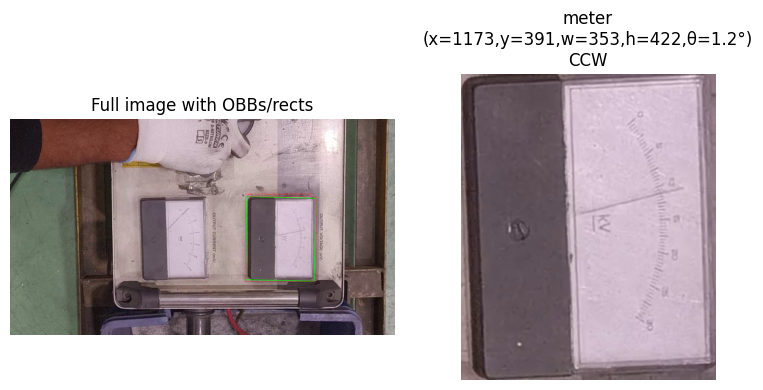

In [24]:
import sys
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

def rotate_crop(crop, angle):
    (h, w) = crop.shape[:2]
    center = (w // 2, h // 2)
    rot_angle = angle  # Always CCW
    M = cv2.getRotationMatrix2D(center, rot_angle, 1.0)
    rotated = cv2.warpAffine(crop, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def order_points(pts):
    # Order points: top-left, top-right, bottom-right, bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def get_crops_and_boxes(image, obbs):
    crops = []
    coords = []
    obb_pts = []
    angles = []
    for obb in obbs:
        pts = obb.cpu().numpy().reshape(-1, 2).astype(np.float32)
        obb_pts.append(pts.astype(np.int32))
        # Order the points
        rect = order_points(pts)
        (tl, tr, br, bl) = rect
        # Compute width and height of the new image
        widthA = np.linalg.norm(br - bl)
        widthB = np.linalg.norm(tr - tl)
        maxW = int(max(widthA, widthB))
        heightA = np.linalg.norm(tr - br)
        heightB = np.linalg.norm(tl - bl)
        maxH = int(max(heightA, heightB))
        # Destination points for "straight" rectangle
        dst = np.array([
            [0, 0],
            [maxW - 1, 0],
            [maxW - 1, maxH - 1],
            [0, maxH - 1]
        ], dtype="float32")
        # Perspective transform
        M = cv2.getPerspectiveTransform(rect, dst)
        crop = cv2.warpPerspective(image, M, (maxW, maxH))
        crops.append(crop)
        x, y, w, h = cv2.boundingRect(pts.astype(np.int32))
        coords.append((x, y, w, h))
        # Get rotation angle using minAreaRect
        rect_box = cv2.minAreaRect(pts)
        angle = rect_box[2]
        angles.append(angle)
    return crops, coords, obb_pts, angles

def visualize_with_matplotlib(orig_bgr, crops, coords, obb_pts, angles, class_names):
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB).copy()
    # Draw OBBs and axis-aligned boxes
    for pts, (x, y, w, h), angle, cname in zip(obb_pts, coords, angles, class_names):
        cv2.polylines(orig_rgb, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.rectangle(orig_rgb, (x, y), (x + w, y + h), (255, 0, 0), 1)
        label = f"{cname} (x={x},y={y},w={w},h={h},θ={angle:.1f}°)"
        cv2.putText(orig_rgb, label, (x, y - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 1)

    n_crops = len(crops)
    fig, axes = plt.subplots(1, n_crops + 1, figsize=(4 * (n_crops + 1), 4))
    axes[0].imshow(orig_rgb)
    axes[0].set_title("Full image with OBBs/rects")
    axes[0].axis("off")

    for i, (crop_bgr, (x, y, w, h), angle, cname) in enumerate(zip(crops, coords, angles, class_names), start=1):
        crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
        rotated_crop = rotate_crop(crop_rgb, angle)
        direction = "CCW" if angle < 90 else "CW"
        axes[i].imshow(rotated_crop)
        axes[i].set_title(f"{cname}\n(x={x},y={y},w={w},h={h},θ={angle:.1f}°)\n{direction}")
        axes[i].axis("off")


    plt.tight_layout()
    plt.show()

def main(analog_box, image_path):
    model = YOLO(analog_box)
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image at", image_path)
        sys.exit(1)

    results = model(image)
    all_obbs = []
    all_names = []
    for r in results:
        if r.obb is not None:
            all_obbs.extend(r.obb.xyxyxyxy)
            for cls_id in r.obb.cls.cpu().numpy():
                all_names.append(r.names[int(cls_id)])

    if not all_obbs:
        print("No oriented boxes detected.")
        return

    crops, coords, obb_pts, angles = get_crops_and_boxes(image, all_obbs)
    visualize_with_matplotlib(image, crops, coords, obb_pts, angles, all_names)

if __name__ == "__main__":
    analog_box = "Models/analog_box_v2.pt"
    image_path = "extracted_frames/189.png"
    main(analog_box, image_path)

## No obb Detect crops save 

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 1. Configure paths
model_path = "Models/res_detect2.pt"            # your YOLO .pt file
dataset_folder = "test/res"                    # folder with images
output_folder = "test/digit"              # where to save crops

os.makedirs(output_folder, exist_ok=True)

# 2. Load model
model = YOLO(model_path)

# 3. Loop through images in dataset folder
for img_name in os.listdir(dataset_folder):
    if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    image_path = os.path.join(dataset_folder, img_name)
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Cannot read {image_path}")
        continue

    # 4. Run inference
    results = model.predict(source=img_bgr, verbose=False)[0]
    names = results.names  # dict: class_id → class_name

    # 5. Loop over detections
    if results.boxes is not None:
        for i, (box, conf, cls) in enumerate(zip(
            results.boxes.xyxy.cpu().numpy(),
            results.boxes.conf.cpu().numpy(),
            results.boxes.cls.cpu().numpy().astype(int)
        )):
            x1, y1, x2, y2 = box.astype(int)
            crop = img_bgr[y1:y2, x1:x2]
            if crop.size == 0:
                continue
            # Save crop
            crop_filename = f"{os.path.splitext(img_name)[0]}_det{i}_{names[cls]}_{conf:.2f}.jpg"
            crop_path = os.path.join(output_folder, crop_filename)
            cv2.imwrite(crop_path, crop)
    else:
        print(f"No detections in {img_name}")

    print(f"Processed {img_name}")

print("Cropping complete. Cropped images saved to", output_folder)

Processed 1.jpg
Processed 1000_res_535_434.jpg
Processed 1001_res_600_417.jpg
Processed 1002_res_674_420.jpg
Processed 1003_res_733_392.jpg
Processed 1100_res_603_603.jpg
Processed 1101_res_622_556.jpg
Processed 1102_res_623_525.jpg
Processed 1103_res_631_513.jpg
Processed 1104_res_627_452.jpg
Processed 1105_res_628_353.jpg
Processed 1106_res_773_372.jpg
Processed 1107_res_652_416.jpg
Processed 1108_res_618_415.jpg
Processed 1109_res_610_400.jpg
Processed 1110_res_625_435.jpg
Processed 1111_res_713_427.jpg
Processed 1112_res_669_529.jpg
Processed 1113_res_658_612.jpg
Processed 1114_res_622_508.jpg
Processed 1115_res_613_424.jpg
Processed 1116_res_808_382.jpg
Processed 1117_res_772_341.jpg
Processed 1118_res_754_316.jpg
Processed 1119_res_734_430.jpg
Processed 1120_res_616_463.jpg
Processed 1121_res_614_456.jpg
Processed 1122_res_630_459.jpg
Processed 1123_res_579_646.jpg
Processed 1124_res_756_556.jpg
Processed 1125_res_629_508.jpg
Processed 1126_res_701_483.jpg
Processed 1127_res_675_